In [ ]:
# !pip install mediapipe

In [1]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import mediapipe as mp
import matplotlib.pyplot as plt

import cv2
import numpy as np

from preprocessing import *

In [122]:
with HandLandmarker.create_from_options(options) as landmarker:
    # Start a webcam capture session:
    cap = cv2.VideoCapture(0)
    timestamp = 0
    while True:
        timestamp += 1
        # Capture a frame from the webcam:
        ret, frame = cap.read()
        if not ret:
            break

        
        mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
        hand_landmarker_result = landmarker.detect_for_video(mp_image, timestamp)
        annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), hand_landmarker_result)
        data = process_hand_landmarks(hand_landmarker_result)
        # save data nparray in a dataset folder
        # Convert the frame back to BGR for OpenCV:
        annotated_imagege = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)


        # Display the frame with hand landmarks:
        cv2.imshow('Hand Landmarker', annotated_image)

        # Press 'q' to quit:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam capture:
    cap.release()
    cv2.destroyAllWindows()


p:\SignFingeringDetection\env\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


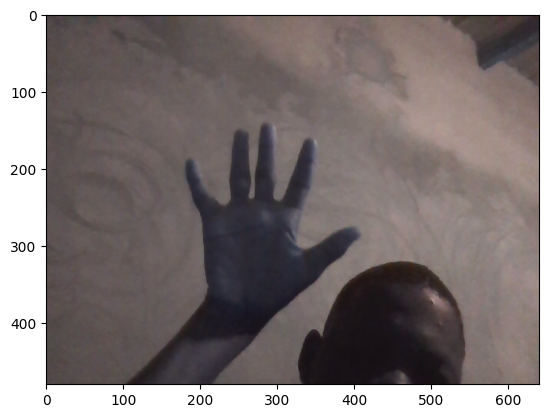

In [110]:
plt.imshow(frame)

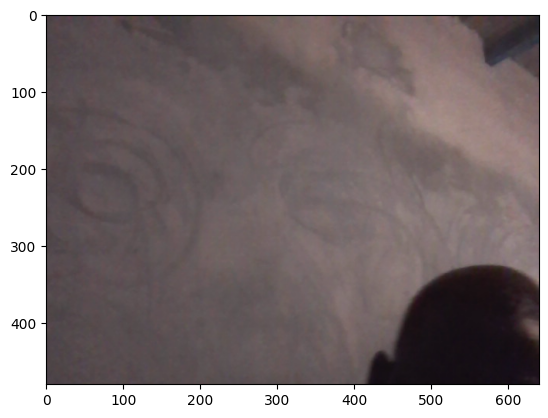

In [123]:
plt.imshow(annotated_image)

In [124]:
hand_landmarker_result

HandLandmarkerResult(handedness=[], hand_landmarks=[], hand_world_landmarks=[])

In [130]:
hand_data = process_hand_landmarks(hand_landmarker_result)

In [131]:
hand_data.min(), hand_data.max(), hand_data.shape

(0.0, 0.0, (126,))

# Load Data

In [1]:
import os
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
DATASET_PATH = os.path.join('dataset')
actions = os.listdir(DATASET_PATH)
labels_map = {}

frames, labels_indexes, labels_text = [], [], []
for i, action in enumerate(actions):
    labels_map[action] = i
    for frame in os.listdir(os.path.join(DATASET_PATH, action)):
        frames.append(np.load(os.path.join(DATASET_PATH, action, frame)))
        labels_text.append(action)
        labels_indexes.append(i)
        

frames = np.array(frames)
labels_text = np.array(labels_text)
labels_indexes = to_categorical(labels_indexes).astype(int)
frames_train, frames_test, labels_train, labels_test = train_test_split(frames, labels_indexes, test_size=.2, shuffle=True)

In [3]:
print(frames.shape, labels_indexes.shape)
print(frames_train.shape, frames_test.shape, labels_train.shape, labels_test.shape)

(41, 126) (41, 2)
(32, 126) (9, 126) (32, 2) (9, 2)


# Visualize the data

In [4]:
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import matplotlib.pyplot as plt
import random

In [5]:
def landmarks_to_image(flattened_landmarks, offset=-0.3):
    image_shape = (480, 640, 3)
    background_image = np.zeros(image_shape, np.uint8)
    background_image[:] = (200, 200, 200)  # RGB value for white
    hand_landmarks_list = [flattened_landmarks[:21*3] + offset, flattened_landmarks[21*3:] + offset]
    annotated_image = np.copy(background_image)

    # Loop through the detected hands to visualize.
    for idx in range(len(hand_landmarks_list)):
        hand_landmarks = hand_landmarks_list[idx]

        # Draw the hand landmarks.
        hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        hand_landmarks_proto.landmark.extend([
            landmark_pb2.NormalizedLandmark(x=hand_landmarks[i], y=hand_landmarks[i+1], z=hand_landmarks[i+2]) 
            for i in range(0, len(hand_landmarks), 3)
        ])
        solutions.drawing_utils.draw_landmarks(
            annotated_image,
            hand_landmarks_proto,
            solutions.hands.HAND_CONNECTIONS,
            solutions.drawing_styles.get_default_hand_landmarks_style(),
            solutions.drawing_styles.get_default_hand_connections_style()
        )

    return annotated_image

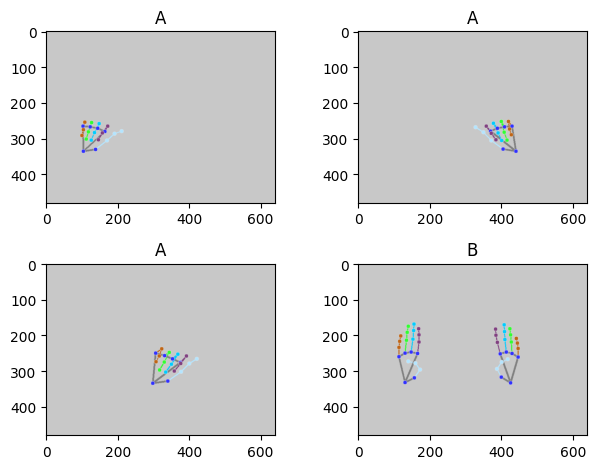

In [6]:
# Randomly sample 4 indices from each dataset
indices = random.sample(range(len(frames)), 4)
# Retrieve the images and labels
sampled_frames = [landmarks_to_image(frames[i], offset= -0.3) for i in indices]
sampled_labels = [labels_text[i] for i in indices]

fig, axes = plt.subplots(2, 2)
for i in range(4):
    axes.flatten()[i].imshow(sampled_frames[i])
    axes.flatten()[i].set_title(f'{sampled_labels[i].upper()}')
    # axes.flatten()[i].axis('off')
    
plt.tight_layout()
plt.show()

# Model the Neural Network

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras import callbacks

In [8]:
input_shape = (126,)
output_shape = (len(actions))

model = Sequential([
    layers.Input(input_shape),
    layers.Dense(128),
    layers.Dropout(0.2),
    layers.Dense(64),
    layers.Dropout(0.2),
    layers.Dense(16),
    layers.Dense(output_shape, activation='softmax')
])

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
        )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,586 (99.95 KB)

 Trainable params: 25,586 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
EPOCHS=25

earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights=True)

history = model.fit(
  frames_train, labels_train,
  validation_data=(frames_test, labels_test),
  epochs=EPOCHS,
  callbacks=[earlystopping]
)

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5938 - loss: 0.8794 - val_accuracy: 0.6667 - val_loss: 0.7202
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5312 - loss: 0.9470 - val_accuracy: 0.4444 - val_loss: 0.7600
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4375 - loss: 0.9488 - val_accuracy: 0.6667 - val_loss: 0.6734
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5625 - loss: 0.7626 - val_accuracy: 0.5556 - val_loss: 0.6590
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5000 - loss: 0.8390 - val_accuracy: 0.5556 - val_loss: 0.6566
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5625 - loss: 0.7728 - val_accuracy: 0.4444 - val_loss: 0.6451
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6875 - loss: 0.6629 - val_accuracy: 0.7778 - val_loss: 0.6702
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6250 - loss: 0.7380 - val_accuracy: 0.6667 - val_loss: 0.7246
Ep

# Visualize training results

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

ValueError: x and y must have same first dimension, but have shapes (25,) and (12,)

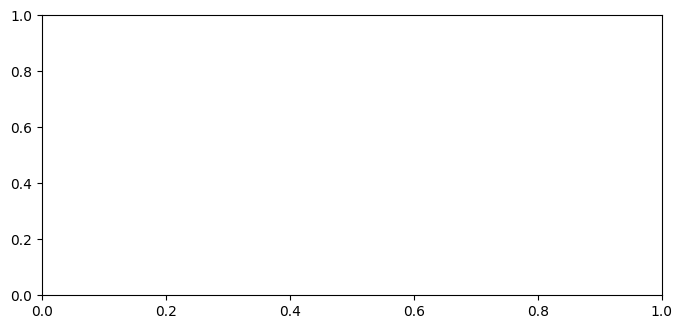

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

# Predicting

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
predictions = model.predict(frames_train)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


In [ ]:
confusion_matrix = tf.math.confusion_matrix(
    labels_train,
    predictions
)

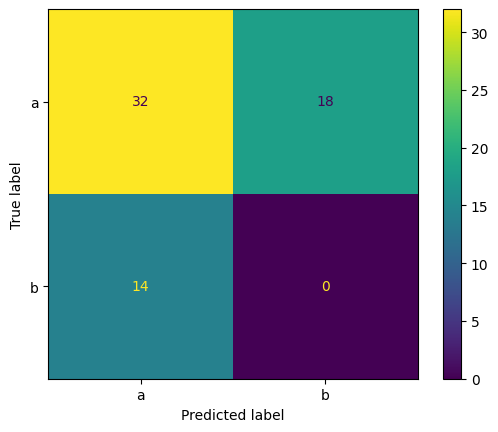

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix.numpy(), 
    display_labels=actions)
disp.plot()